Detect cloud bands between on 23 and 30 Nov 2007 using ERA5 3 hourly olr data, and create maps showing the evolution of the cloud bands.

In [1]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.io_utilities import load_ymlfile, add_startend_datetime2config, get_variable_lonlat_from_domain
from cloudbandpy.load_driver import run_load_data
from cloudbandpy.misc import wrapTo180
from cloudbandpy.time_utilities import create_list_of_dates

warnings.filterwarnings("ignore")

Load configuration file and make adjustements for this test case

In [2]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_cbworkflow_northPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Changing configs to adapt to this particular example
config_event["startdate"] = "20071123.00"
config_event["enddate"] = "20071130.00"
# update datetime dates from config file
add_startend_datetime2config(config_event)
dirdata = "data/"
config_event["clouddata_path"] = os.path.join(base_dir, "data")
config_event["parameters_file"] = os.path.join(
    base_dir, "parameters/parameters_northhemisphere.yml"
)
# No need to save any files
config_event["saved_dirpath"] = ""
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

listofdates = create_list_of_dates(config_event)

2025-01-13 16:32:32,413 - io_utilities.load_ymlfile - INFO: Configuration file loaded


Load ERA5 data and get its resolution, and load parameters file. The ERA5 file contains OLR data from 01.01.2016 to 30.05.2016.

In [3]:
olr2process, parameters, lats_in, lons_in, resolution = run_load_data(config_event)

2025-01-13 16:32:32,420 - load_driver.run_load_data - INFO: Loading data and parameters 
2025-01-13 16:32:32,424 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2025-01-13 16:32:32,425 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2025-01-13 16:32:32,426 - io_utilities.load_dataset - INFO: Loading 2007 --> 2007
2025-01-13 16:32:33,654 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2025-01-13 16:32:33,657 - io_utilities.make_daily_average - INFO: Computation of daily average
2025-01-13 16:32:33,774 - io_utilities.make_daily_average - INFO: Computation of daily average done
2025-01-13 16:32:33,776 - io_utilities.load_dataset - INFO: Dataset loaded


Crop variable to domain of detection

In [4]:
lat_north = config_event["lat_north"]
lat_south = config_event["lat_south"]
lon_west = config_event["lon_west"]
lon_east = config_event["lon_east"]
olr, lons, lats = get_variable_lonlat_from_domain(olr2process, lons_in, lats_in, lon_west, lon_east, lat_north, lat_south)

2025-01-13 16:32:33,809 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done


Run cloud band detection

In [5]:
(
        _,
        _,
        labelled_blobs,
        labelled_candidates,
        cloud_bands_over_time,
        _,
        _,
    ) = detection_workflow(
        var2process=olr,
        parameters=parameters,
        latitudes=lats,
        longitudes=lons,
        resolution=resolution,
        listofdates=listofdates,
        config=config_event,
    )

2025-01-13 16:32:33,816 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2025-01-13 16:32:33,910 - cb_detection.detection_workflow - INFO: Cloud band detection done


Create the series of maps which show the evolution of cloud bands over time

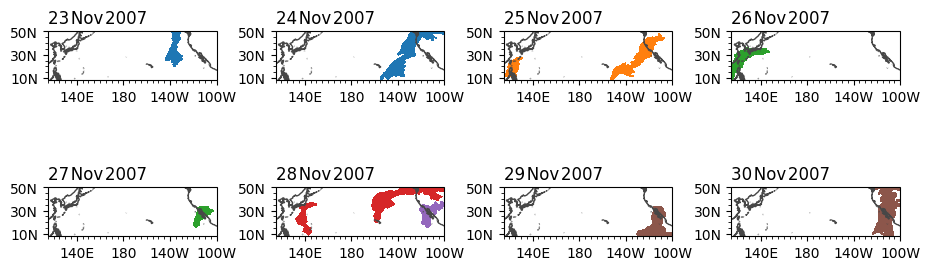

In [6]:
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")
lat_north, lat_south = round(lats[0]), round(lats[-1])
daystart = f"{listofdates[0].day}-{listofdates[0].strftime('%m')}-{listofdates[0].year}"
dayend = f"{listofdates[-1].day}-{listofdates[-1].strftime('%m')}-{listofdates[-1].year}"

unique_ids = np.unique(cloud_bands_over_time)
id_mapping = {val: idx for idx, val in enumerate(unique_ids)}
normalized_cloud_bands = np.vectorize(id_mapping.get)(cloud_bands_over_time)

fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
    figsize=(11, 4),
)
for inc, ax in enumerate(axs.ravel()):
    ax.contourf(
        lons, lats, np.ma.masked_where(normalized_cloud_bands[inc] == 0, normalized_cloud_bands[inc]),
        transform=ccrs.PlateCarree(), levels=range(20), cmap="tab10",
    )
    lonticks = np.concatenate((np.arange(20,180,40),np.arange(-200, 0, 40)))
    latticks = np.arange(-90, 110, 20)
    ax.set_xticks(lonticks, crs=ccrs.PlateCarree())
    ax.set_yticks(latticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LON_FORMAT)
    ax.yaxis.set_major_formatter(LAT_FORMAT)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(40))
    ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
    ax.set_ylim([lat_south, lat_north])
    ax.coastlines(color="#474747")
    ax.set_title(
        f"{listofdates[inc].day}\u200A{listofdates[inc].strftime('%b')}\u200A{listofdates[inc].year}",
        loc="left",
    )
#
fig.subplots_adjust(wspace=0.35, hspace=0.025)